<a href="https://colab.research.google.com/github/huyngkh/beauty_evaluation/blob/master/beauty_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from tqdm import tqdm
import cv2
import pandas as pd
import os
import random
import time
import imutils
import math
import matplotlib.pyplot as plt

# from tensorflow.keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam

In [54]:
def get_labels(file):
    with open(file,'r') as f:
        lines = f.readlines()
        return np.array([line.strip().split() for line in lines])
    
def index_process(flo):
    below = math.floor(flo)
    top = math.ceil(flo)
    
    result = np.zeros(5)
    result[below-1] = top-round(flo)
    result[top-1] = round(flo)-below
    
    return result

#loading of images and labels
#Cross validation was made by the dataset provider
TRAIN_TEST_PATH = '/content/train_test_files/'
train_labels = get_labels(TRAIN_TEST_PATH+'train.txt')
test_labels = get_labels(TRAIN_TEST_PATH+'test.txt')

print(test_labels)
PATH_IMAGES = '/content/Images/'
X_pre_train = [cv2.imread(PATH_IMAGES+file,0) for file in tqdm(train_labels[:,0])]
X_train = np.array([cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA) for img in X_pre_train])

X_pre_test = [cv2.imread(PATH_IMAGES+file,0) for file in tqdm(test_labels[:,0])]
X_test = np.array([cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA) for img in X_pre_test])

y_train = np.array([float(flo) for flo in train_labels[:,1]])
y_test = np.array([float(flo) for flo in test_labels[:,1]])

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
X_train.shape,y_train.shape

  1%|          | 18/3300 [00:00<00:18, 173.95it/s]

[['CM423.jpg' '2.8']
 ['AF1176.jpg' '2.366667']
 ['AM354.jpg' '2.616667']
 ...
 ['AM388.jpg' '2.666667']
 ['AM930.jpg' '2.483333']
 ['AM5.jpg' '2.3']]


100%|██████████| 2200/2200 [00:03<00:00, 665.46it/s]


((3300, 224, 224, 1), (3300,))

In [80]:
!rm *.h5

  adding: best_model.h5 (deflated 8%)


In [55]:
# def euclidean_distance_loss(y_true, y_pred):
#     """
#     Euclidean distance loss
#     https://en.wikipedia.org/wiki/Euclidean_distance
#     :param y_true: TensorFlow/Theano tensor
#     :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
#     :return: float
#     """
#     return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [ ]:
# resnet = ResNet50(include_top=False, pooling='avg', input_shape=((224,224,3)))

In [ ]:
# model = Sequential()
# model.add(resnet)
# model.add(Dropout(0.5))
# model.add(Dense(5, activation='softmax'))
# model.layers[0].trainable = False
# print (model.summary())

In [56]:
class Beau:
    def __init__(self):

        self.model = Sequential()

        #1st 2dConvolutional Layer
        self.model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 1)))
        self.model.add(Activation('relu'))

        #1st 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))

        #2nd 2dConvolutional Layer
        self.model.add(Conv2D(64, (3, 3), padding='same'))
        self.model.add(Activation('relu'))

        #2nd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))

        #3rd 2dConvolutional Layer
        self.model.add(Conv2D(128, (5, 5), padding='same'))
        self.model.add(Activation('relu'))

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        #4th 2dConvolutional Layer
        self.model.add(Conv2D(128, (5, 5), padding='same'))
        self.model.add(Activation('relu'))

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        #5th 2dConvolutional Layer
        self.model.add(Conv2D(256, (3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        #6th 2dConvolutional Layer
        self.model.add(Conv2D(512, (5, 5), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling2D(pool_size=(1, 1)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))

        self.model.add(Conv2D(1024, (5, 5), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(Flatten())

        #1st FC Layer
        self.model.add(Dense(256))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.25))
        
        #2nd FC Layer
        self.model.add(Dense(512))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.25))

        # Output layer
        self.model.add(Dense(1))
        self.model.add(Activation('relu'))

        # self.model.summary()

In [57]:
model = Beau().model
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
activation_140 (Activation)  (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_154 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
dropout_112 (Dropout)        (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
activation_141 (Activation)  (None, 112, 112, 64)    

In [85]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='kld', optimizer=sgd, metrics=['accuracy'])
# # model.compile(loss=euclidean_distance_loss, optimizer=sgd, metrics=['accuracy'])
# root_mean_squared_error = root_mean_squared_error
model.compile(optimizer=sgd, loss=root_mean_squared_error, metrics=root_mean_squared_error)
earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
filepath = "{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(X_train, y_train, callbacks=[earlyStopping, checkpoint],
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(X_test, y_test))

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.4745 - root_mean_squared_error: 0.4745
Epoch 00001: val_loss improved from inf to 0.50389, saving model to 01-0.50.h5
26/26 [==============================] - 8s 297ms/step - loss: 0.4745 - root_mean_squared_error: 0.4745 - val_loss: 0.5039 - val_root_mean_squared_error: 0.5039
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.4596 - root_mean_squared_error: 0.4596
Epoch 00002: val_loss did not improve from 0.50389
26/26 [==============================] - 7s 261ms/step - loss: 0.4596 - root_mean_squared_error: 0.4596 - val_loss: 0.5108 - val_root_mean_squared_error: 0.5108
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.4715 - root_mean_squared_error: 0.4715
Epoch 00003: val_loss did not improve from 0.50389
26/26 [==============================] - 7s 260ms/step - loss: 0.4715 - root_mean_squared_error: 0.4715 - val_loss: 0.5113 - val_root_mean_squared_error: 0.5113
Epoch 

Text(0.5, 0, 'Epoch')

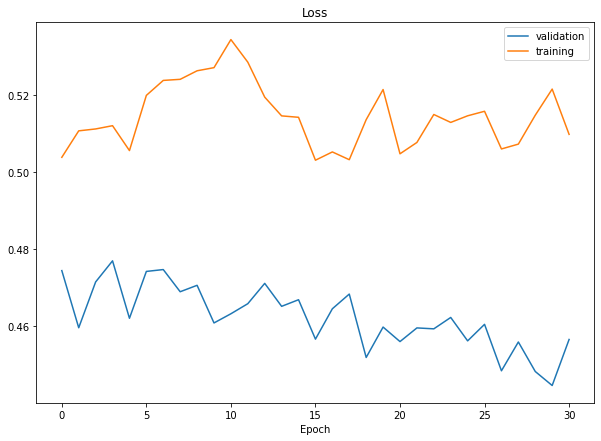

In [86]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['validation','training'])
plt.title('Loss')
plt.xlabel('Epoch')

In [73]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json1", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./best_model.h5")
print("Saved model to disk")

Saved model to disk


[3.32329]


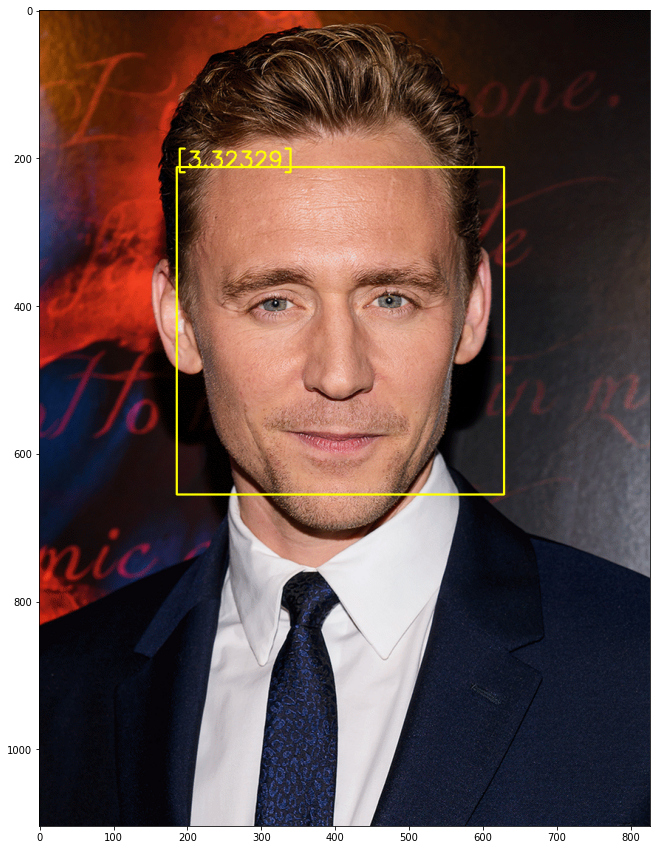

In [79]:
import imutils
color = [(255,0,0),(0,255,255),(0,255,0),(0,100,255),(0,0,255)][::-1]
imagepath = '/content/sample_data/tom.png'
face_clf = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
Model = Beau()
Model.model.load_weights('/content/best_model.h5')
image_name = imagepath.split('/')[-1]

img = cv2.imread(imagepath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_clf.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    fc = gray[y:y+h, x:x+w]

    roi = cv2.resize(fc, (224, 224))
    roi = roi.reshape((1,224,224,1))
    pred = Model.model.predict(roi)[0] 
    cv2.putText(img, str(pred), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)
    cv2.rectangle(img,(x,y),(x+w,y+h),color[math.floor(pred)],2)
    plt.figure(figsize=(15,15))
    plt.imshow(imutils.opencv2matplotlib(img))

print(pred)
# cv2.imwrite('out'+image_name,img)

In [ ]:
img.shape

(1104, 827, 3)